In [2]:
!pip install scipy pyscf qiskit pylatexenc qiskit-nature qiskit-aer pyberny

In [3]:
import numpy as np
from pyscf import ao2mo, gto, scf
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize

In [4]:
def create_integrals_ib_sto3g():
    # Li3Co3O6(gas phase)
    mol = gto.M(
        atom = '''
        Li  0.0000  0.0000  0.0000
        Co  0.0000  0.0000  2.10
        O   1.25   0.0000  3.20
        O  -1.25   0.0000  3.20
        ''', 
        basis = '6-31G*'
    )
    # do the HF calculation
    hf = scf.RHF(mol)
    hf.kernel()
    # number of electrons (N)
    nelec = mol.nelectron
    # number of orbitals (M)
    norb = hf.mo_coeff.shape[-1]
    # orbital coefficients (C_ji)
    c = hf.mo_coeff
    print(f"nOrb : {norb}")
    print(f"nElec: {nelec}")
    # nuclear repulsion energy E_II
    nuclear = mol.energy_nuc()
    # h^(atom)_ab
    h1atom = hf.get_hcore()
    # hpq = sum_ab C_ap^* C_bq h^(atom)_ab
    # since c is all real (no complex number), we don’t need to conjugate
    hpq = np.einsum("ap,bq,ab->pq", c, c, h1atom)
    use_slow_version = False
    if use_slow_version:
      # SLOW VERSION OF hpqrs
      # hpqrs = sum_abcd C_ap^* C_bq^* C_cr C_ds h^(atom)_abcd
      # PYSCF USES CHEMISTS NOTATION, SO WE NEED TO DO
      # (ps|qr) = sum_adbc C_ap^* C_bq^* C_cr C_ds (ad|bc)^((atom))
      # since c is all real (no complex number), we don’t need to conjugate
      h2atom = mol.intor("int2e")
      hpqrs = np.einsum("ap,bq,cr,ds,adbc->pqrs", c, c, c, c, h2atom)
    else:
      # FASTER VERSION OF hpqrs
      # PYSCF USES CHEMISTS NOTATION, NEED TO CHANGE THE ORDER
      # (ps|qr) -> h_pqrs
      hpqrs = ao2mo.full(mol, c, compact=False).reshape(norb, norb, norb, norb)
      hpqrs = hpqrs.transpose(0, 2, 3, 1)
    return hpq, hpqrs, nuclear, nelec

In [5]:
def create_hamiltonian_quantum_circuit(hpq, hpqrs, mapper):
    # NOTE: we exclude the nuclear term here.
    # We just add the nuclear term to the VQE energy afterwards
    n_spatial_orb = hpq.shape[0]
    n_spin_orb = 2 * n_spatial_orb
    fermionic_op_dict = {}

    for spin in range(2):
        # 0 is UP 1 is DW
        for p_spatial_orb in range(n_spatial_orb):
            for q_spatial_orb in range(n_spatial_orb):
                p_spin_orb = spin * n_spatial_orb + p_spatial_orb
                q_spin_orb = spin * n_spatial_orb + q_spatial_orb
                p_qubit = p_spin_orb
                q_qubit = q_spin_orb
                coeff = hpq[p_spatial_orb, q_spatial_orb]
                fermionic_op_dict[f"+_{p_qubit} -_{q_qubit}"] = coeff

    for spin_ps in range(2):
        for spin_qr in range(2):
            for p_spatial_orb in range(n_spatial_orb):
                for q_spatial_orb in range(n_spatial_orb):
                    for r_spatial_orb in range(n_spatial_orb):
                        for s_spatial_orb in range(n_spatial_orb):
                            p_spin_orb = spin_ps * n_spatial_orb + p_spatial_orb
                            q_spin_orb = spin_qr * n_spatial_orb + q_spatial_orb
                            r_spin_orb = spin_qr * n_spatial_orb + r_spatial_orb
                            s_spin_orb = spin_ps * n_spatial_orb + s_spatial_orb
                            p_qubit = p_spin_orb
                            q_qubit = q_spin_orb
                            r_qubit = r_spin_orb
                            s_qubit = s_spin_orb
                            coeff = hpqrs[p_spatial_orb, q_spatial_orb, r_spatial_orb, s_spatial_orb]
                            # multiply by 0.5
                            fermionic_op_dict[f"+_{p_qubit} +_{q_qubit} -_{r_qubit} -_{s_qubit}"] = (coeff * 0.5)

    fermionic_op = FermionicOp(fermionic_op_dict, num_spin_orbitals=n_spin_orb)
    qubit_op = mapper.map(fermionic_op)
    return qubit_op

arr = create_integrals_ib_sto3g()
#hamiltonian = create_hamiltonian_quantum_circuit(arr[0], arr[1], JordanWignerMapper())
# hamiltonian.draw("mpl")

converged SCF energy = -1537.93504404175
nOrb : 76
nElec: 46


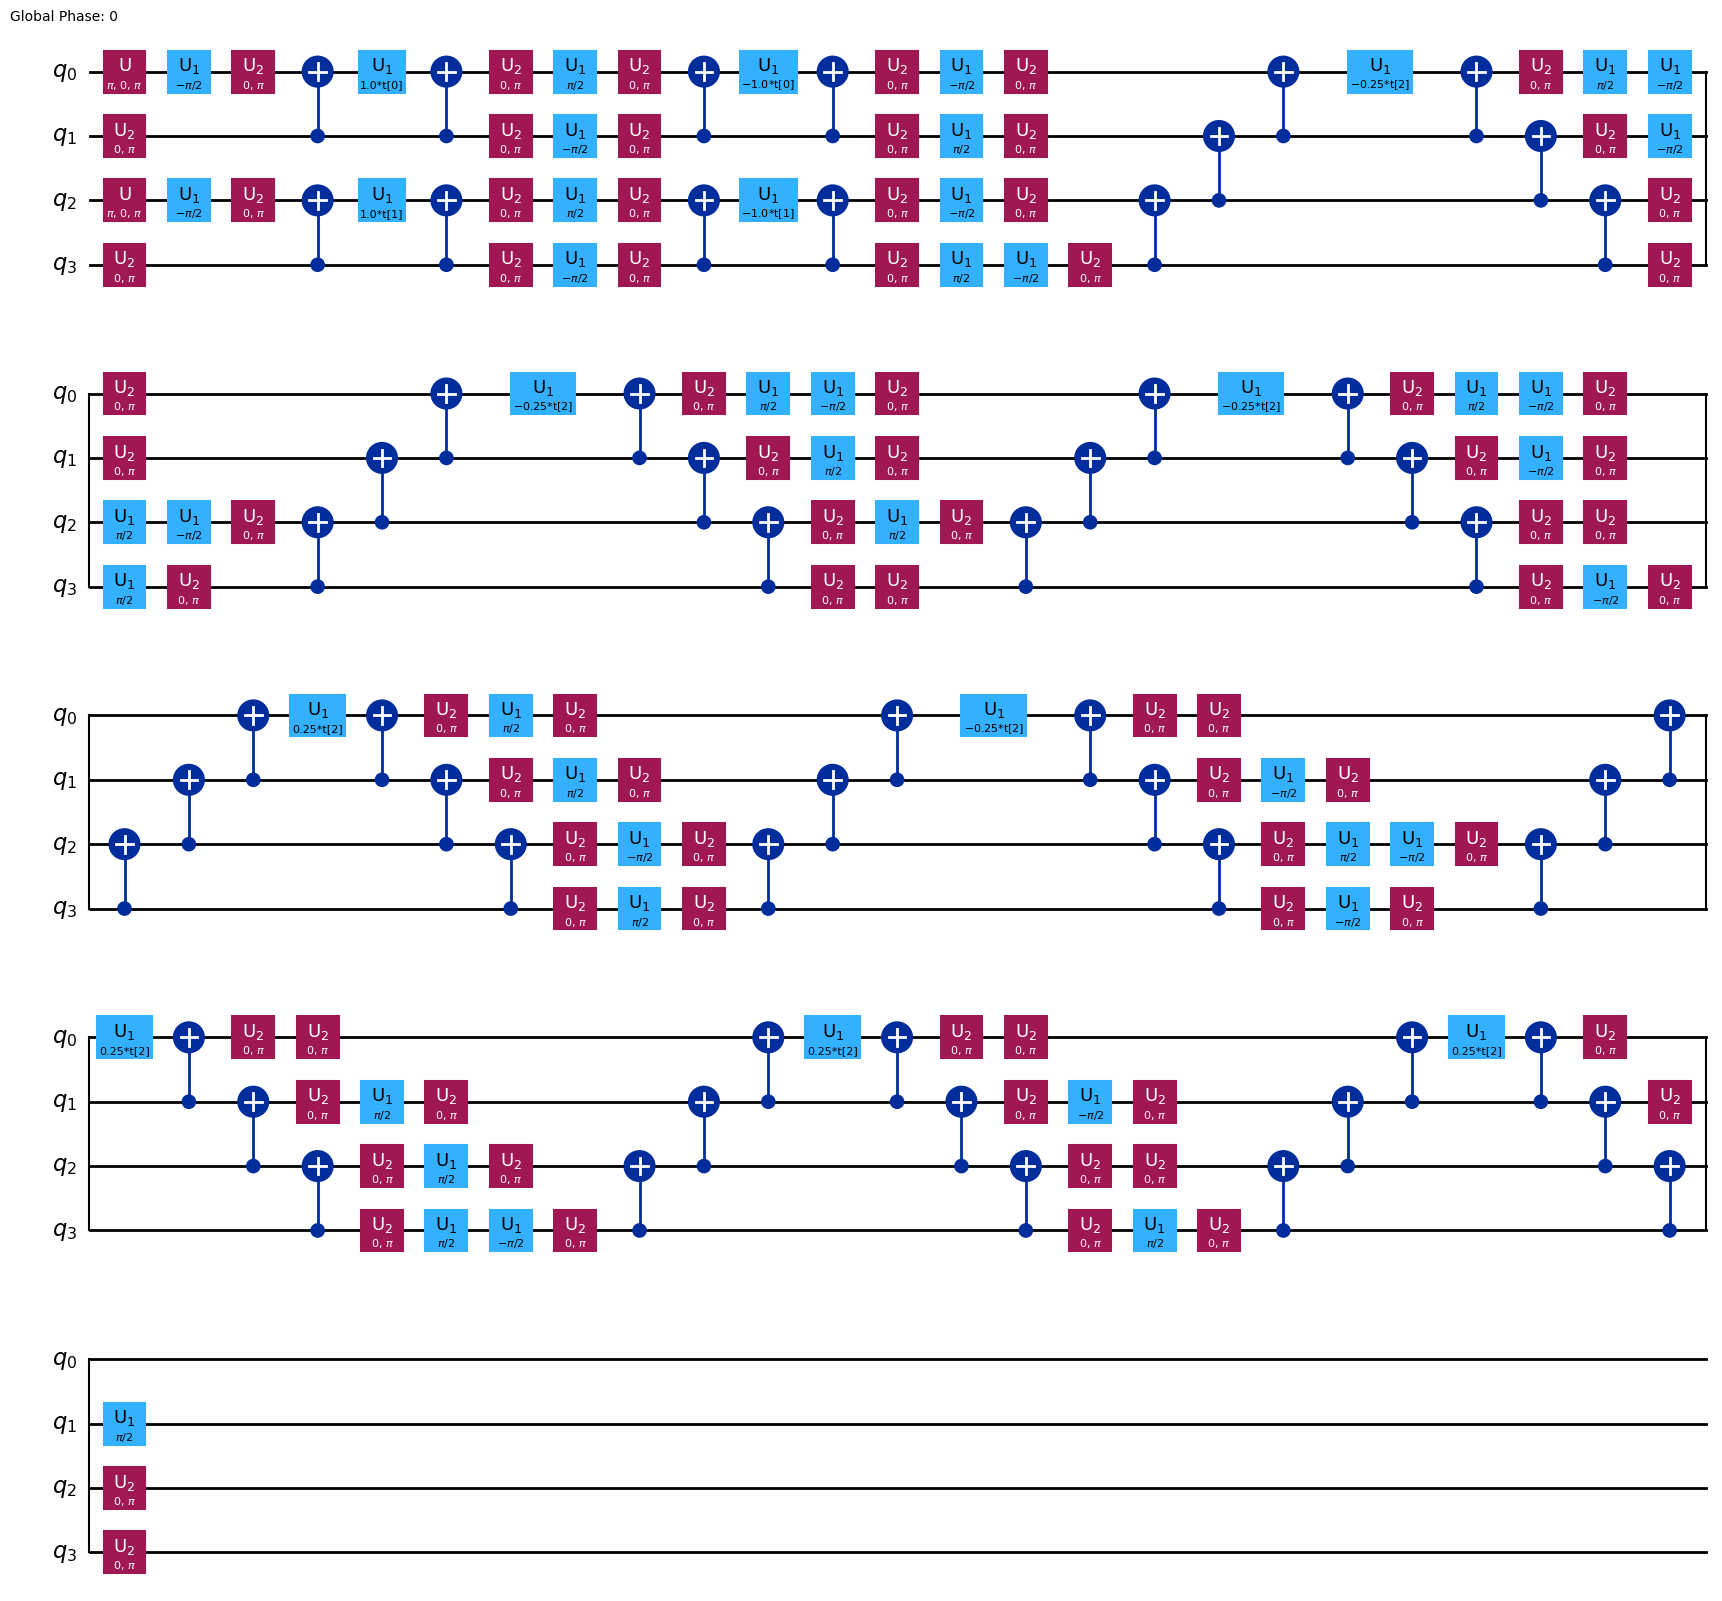

In [6]:
from qiskit.circuit import QuantumCircuit
from qiskit_nature.second_q.circuit.library import UCC

def make_ucc_ansatz(n_spatial_orb, n_elec, mapper, print_circuit=False):
    n_spin_orb = n_spatial_orb * 2
    n_elec_per_spin = n_elec // 2
    # first create the HF state
    n_qubits = n_spin_orb
    hf = QuantumCircuit(n_qubits)

    for spin in range(2):
        # loop over occupied spatial orbitals
        for p_spatial_orb in range(n_elec_per_spin):
            p_spin_orb = spin * n_spatial_orb + p_spatial_orb
            hf.x(p_spin_orb)

    # num_particles: we need to separate number of spin up and spin down electrons
    # excitations: sd -> singles + doubles
    # qubit_mapper: The Jordan Wigner mapper
    # initial state is HF
    ucc = UCC(
        num_spatial_orbitals=n_spatial_orb,
        num_particles=(n_elec_per_spin, n_elec_per_spin),
        excitations="sd",
        qubit_mapper=mapper,
        initial_state=hf,
    )

    if print_circuit:
        ucc_draw = ucc.decompose().decompose().decompose()
        print(ucc_draw.draw("text"))

    return ucc

UCCtest = make_ucc_ansatz(n_spatial_orb=2, n_elec=2, mapper=JordanWignerMapper())
UCCtest.decompose().decompose().decompose().draw("mpl")

     ┌─────────────┐ ░                 ░ ┌─────────────┐ ░                 ░ 
q_0: ┤ R(t[0],π/2) ├─░───■─────────────░─┤ R(t[4],π/2) ├─░───■─────────────░─
     ├─────────────┤ ░ ┌─┴─┐           ░ ├─────────────┤ ░ ┌─┴─┐           ░ 
q_1: ┤ R(t[1],π/2) ├─░─┤ X ├──■────────░─┤ R(t[5],π/2) ├─░─┤ X ├──■────────░─
     ├─────────────┤ ░ └───┘┌─┴─┐      ░ ├─────────────┤ ░ └───┘┌─┴─┐      ░ 
q_2: ┤ R(t[2],π/2) ├─░──────┤ X ├──■───░─┤ R(t[6],π/2) ├─░──────┤ X ├──■───░─
     ├─────────────┤ ░      └───┘┌─┴─┐ ░ ├─────────────┤ ░      └───┘┌─┴─┐ ░ 
q_3: ┤ R(t[3],π/2) ├─░───────────┤ X ├─░─┤ R(t[7],π/2) ├─░───────────┤ X ├─░─
     └─────────────┘ ░           └───┘ ░ └─────────────┘ ░           └───┘ ░ 


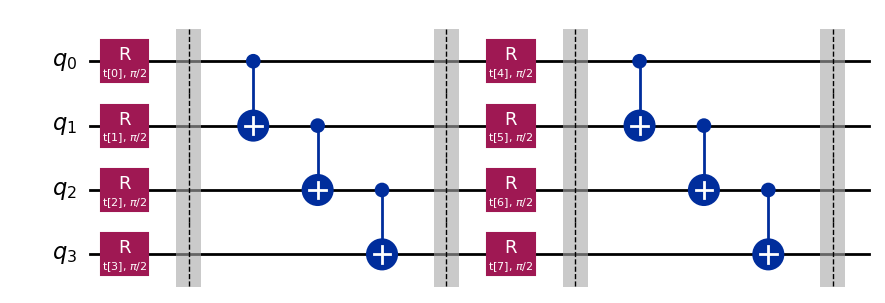

In [7]:
def make_hea_ansatz(n_spatial_orb, reps=2, print_circuit=False):
    n_spin_orb = n_spatial_orb * 2
    n_qubits = n_spin_orb
    n_params = n_qubits * reps
    params = ParameterVector("t", n_params)
    ansatz = QuantumCircuit(n_qubits)
    iparam = 0

    for irep in range(reps):
        for p_spin_orb in range(n_spin_orb):
            ansatz.ry(params[iparam], p_spin_orb)
            iparam += 1
        ansatz.barrier()

        for p_spin_orb in range(n_spin_orb - 1):
            ansatz.cx(p_spin_orb, p_spin_orb + 1)
        ansatz.barrier()

    if print_circuit:
        ansatz_draw = ansatz.decompose()
        print(ansatz_draw.draw("text"))

    return ansatz
HEAtest = make_hea_ansatz(n_spatial_orb=2, reps=2, print_circuit=True)
HEAtest.decompose().draw("mpl")

In [8]:
def do_vqe(ansatz, hamiltonian, nuclear):
  nparams = ansatz.num_parameters
  # theta: set the inital theta to random
  initial_state = np.random.random(nparams)
  # noiseless simulator
  estimator = AerEstimator(run_options={"shots": None}, approximation=True)
  index = 0
  def get_energy(parameter_values):
    nonlocal index
    result = estimator.run(
      circuits=ansatz, observables=hamiltonian, parameter_values=parameter_values
    ).result()
    #print(ansatz.draw("mpl"))
    energy = result.values[0] + nuclear
    index += 1
    parameter_str = " ".join(f"{e:.4f}" for e in parameter_values)
    print(f"{energy:.6f}")
    return energy

  res = minimize(fun=get_energy, x0=initial_state, method="bfgs")
  print(f"Energy: {res.fun}")

#VQEtest = do_vqe(HEAtest, hamiltonian, arr[2])
#VQEtest.draw("mpl")

In [9]:
from pyscf import ao2mo, lib


# NACT HERE IS SPATIAL ORBITALS, NOT SPIN ORBITALS
def active_space_unpolarized(mf, ncore=0, nact=None):
    einsum = lib.einsum

    if nact is None:
        nact = mf.mo_coeff.shape[1] - ncore

    nuclear = mf.mol.energy_nuc()
    ecore = 0.0

    mo_coeff_core = mf.mo_coeff[:, :ncore]
    mo_coeff_acti = mf.mo_coeff[:, ncore : ncore + nact]

    h1atom = mf.get_hcore()
    if ncore != 0:
        dm_ao_core = 2 * mo_coeff_core @ mo_coeff_core.T
        vj, vk = mf.get_jk(mf.mol, dm_ao_core)
        veff_ao = vj - 0.5 * vk
        ecore += einsum("ij,ji->", dm_ao_core, h1atom + 0.5 * veff_ao)
        h1atom += veff_ao
    hpq = einsum("ap,bq,ab->pq", mo_coeff_acti, mo_coeff_acti, h1atom)
    hpqrs = ao2mo.full(mf.mol, mo_coeff_acti, compact=False).reshape(
        nact, nact, nact, nact
    )
    hpqrs = hpqrs.transpose(0, 2, 3, 1)

    act_nelec = mf.mol.nelectron - ncore * 2

    print(f"nElec: {act_nelec}")
    print(f"nAct : {nact}")

    return nact, act_nelec, nuclear + ecore, hpq, hpqrs


# EXAMPLE
import numpy as np
from pyscf import gto, scf

mol = gto.M(
  atom = '''
    Li  0.0000  0.0000  0.0000
    Co  0.0000  0.0000  2.10
    O   1.25   0.0000  3.20
    O  -1.25   0.0000  3.20
  ''',
  basis = '6-31G*'
  )
# do the HF calculation
hf = scf.RHF(mol)
hf.kernel()

nact, act_nelec, nuclear, hpq, hpqrs = active_space_unpolarized(hf, 18, 8)

# DO VQE HERE
mapper = JordanWignerMapper()
hamiltonian = create_hamiltonian_quantum_circuit(hpq, hpqrs, mapper)


converged SCF energy = -1537.93504404189
nElec: 10
nAct : 8


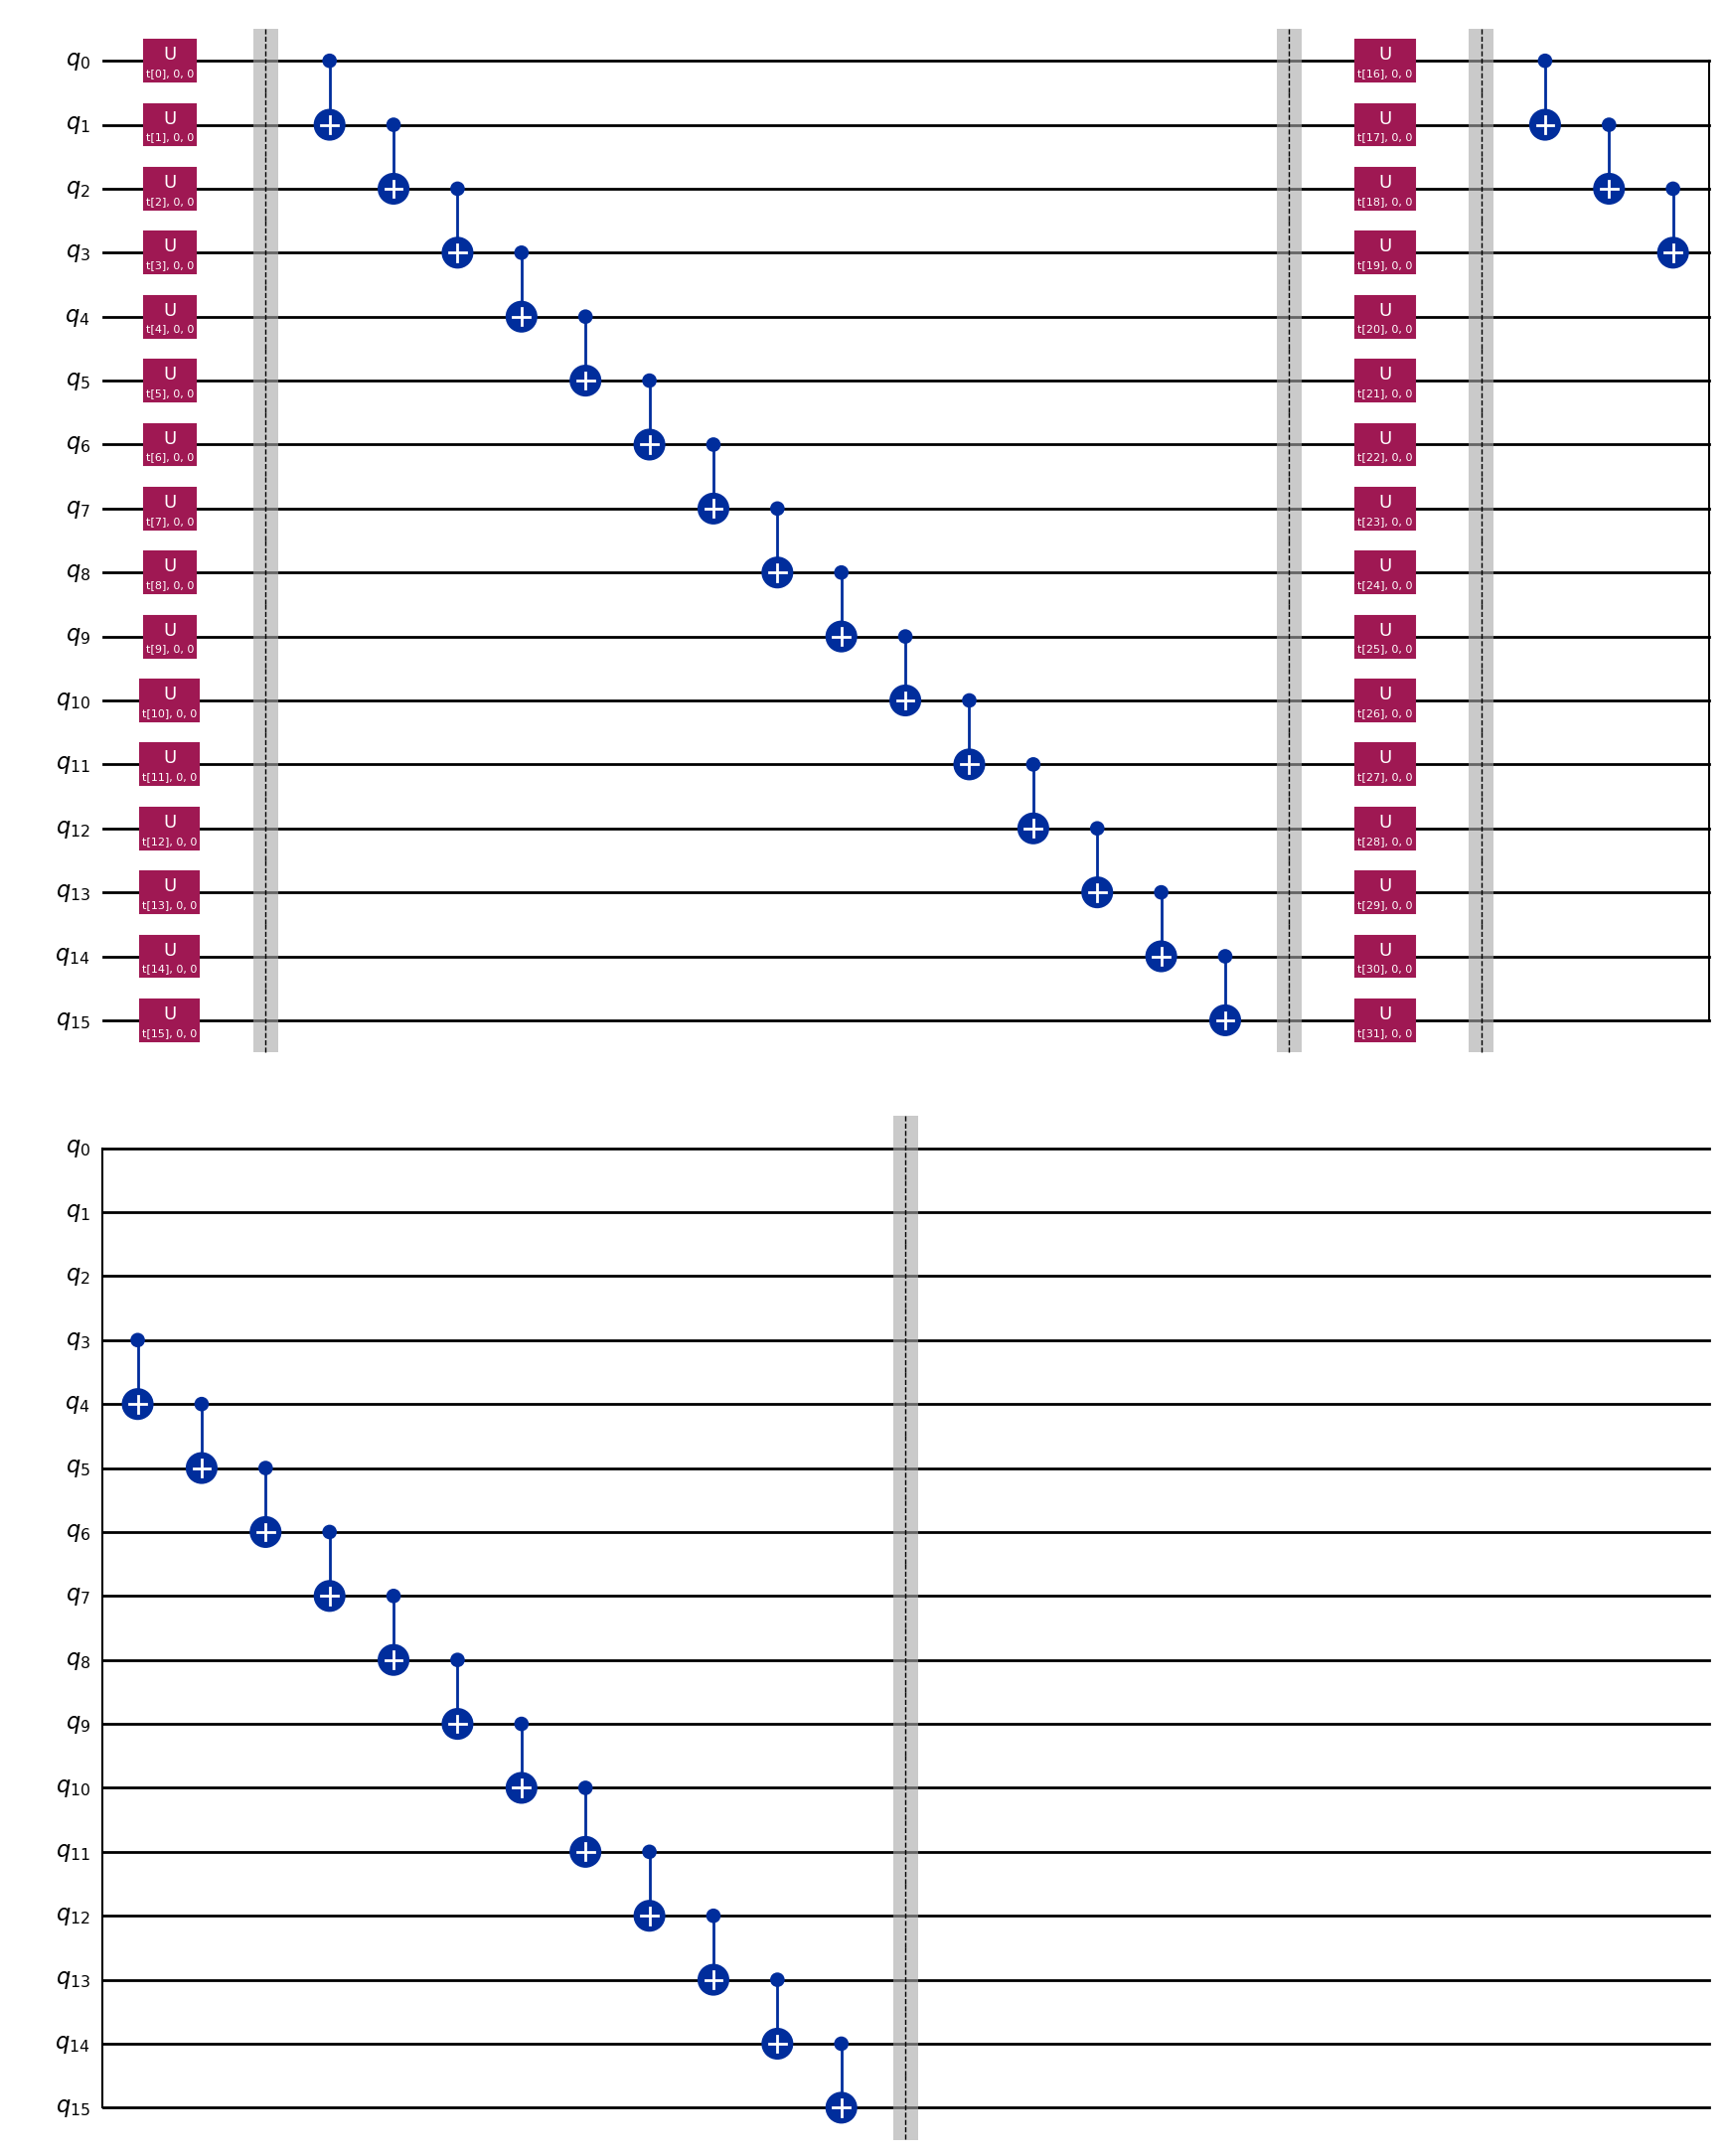

In [34]:
ansatz = make_hea_ansatz(hpq.shape[0], 2, print_circuit=False)
ansatz.decompose().decompose().decompose().draw("mpl")

In [10]:
import numpy as np
from pyscf import ao2mo, gto, scf, lib
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize
# from qiskit_nature.drivers import PySCFDriver
# from qiskit_nature.converters.second_quantization import QubitConverter
# from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
# from qiskit_nature.mappers.second_quantization import ParityMapper
# from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit.quantum_info.analysis import Z2Symmetries
import matplotlib.pyplot as plt

In [10]:
def make_odd_hea_ansatz(n_spin, reps=3, print_circuit=False):
    n_spin_orb = n_spin
    n_qubits = n_spin_orb
    n_params = n_qubits * reps
    params = ParameterVector("t", n_params)
    ansatz = QuantumCircuit(n_qubits)
    iparam = 0

    for irep in range(reps):
        for p_spin_orb in range(n_spin_orb):
            ansatz.ry(params[iparam], p_spin_orb)
            iparam += 1
        ansatz.barrier()

        for p_spin_orb in range(n_spin_orb - 1):
            ansatz.cx(p_spin_orb, p_spin_orb + 1)
        ansatz.barrier()

    if print_circuit:
        ansatz_draw = ansatz.decompose()
        print(ansatz_draw.draw("text"))

    return ansatz
# HEAtest = make_hea_ansatz(n_spatial_orb=arr_active[0], reps=2, print_circuit=False)

In [12]:
from qiskit.quantum_info.analysis import Z2Symmetries
z2_symmetries = Z2Symmetries.find_z2_symmetries(hamiltonian)
#print(z2_symmetries)
tapered_op = z2_symmetries.taper(hamiltonian)
do_vqe(make_odd_hea_ansatz(13), tapered_op[6], nuclear)
#do_vqe(ansatz, hamiltonian, nuclear)
#do_vqe(make_ucc_ansatz(n_spatial_orb=13, n_elec=2, mapper=JordanWignerMapper()), tapered_op[6], nuclear)

-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1533.083766
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281
-1534.375281